In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
features = ['pclass' , 'sex' , 'age' , 'sibsp' ,'parch','fare','class','who','adult_male','alone']
target = 'survived'

X = titanic[features]
y = titanic[target]


In [5]:
y.value_counts()
#Here becuase the data is slightly skewed, we use stratification, which wil cause all training data to have 
#same proprtions

survived
0    549
1    342
Name: count, dtype: int64

In [6]:
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42, stratify=y)

In [7]:
#We must separate numerical and categorical features to apply different types of scaling methods hence

numerical_features = X_train.select_dtypes(include=['number']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object','category']).columns.tolist()


In [8]:
'''This is why we separeted, so that we can apply repsective preprocesssing techniques'''

num_trans = Pipeline(
    steps = [
        ('imputer' , SimpleImputer(strategy='median')),
        ('scaler' , StandardScaler())
    ]
)

cat_trans = Pipeline(
    steps = [
        ('imputer' , SimpleImputer(strategy='most_frequent')),
        ('onehot' , OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [9]:
preproc = ColumnTransformer(
    transformers=[
        ('num' , num_trans, numerical_features),
        ('cat' , cat_trans , cat_features)
    ]
)

In [10]:
pipe = Pipeline(
    steps = [
        ('pre' , preproc),
        ('class' , RandomForestClassifier(random_state=42))
    ]
)

In [11]:
'''Hyperparameters- Parameters of the model that you chose, we can control this'''

param_grid = {
    'class__n_estimators': [50,100],
    'class__max_depth' : [None,10,20],
    'class__min_samples_split' :[2,5]
}

In [12]:
cv = StratifiedKFold(n_splits= 5, shuffle=True)
#Stratitifed KFLod means balanced dataset for each fold- better training for model

In [13]:
model = GridSearchCV(
    estimator=pipe,
    param_grid= param_grid,
    cv = cv,
    scoring = 'accuracy',
    verbose = 2

)

model.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END class__max_depth=None, class__min_samples_split=2, class__n_estimators=50; total time=   0.1s
[CV] END class__max_depth=None, class__min_samples_split=2, class__n_estimators=50; total time=   0.0s
[CV] END class__max_depth=None, class__min_samples_split=2, class__n_estimators=50; total time=   0.0s
[CV] END class__max_depth=None, class__min_samples_split=2, class__n_estimators=50; total time=   0.0s
[CV] END class__max_depth=None, class__min_samples_split=2, class__n_estimators=50; total time=   0.0s
[CV] END class__max_depth=None, class__min_samples_split=2, class__n_estimators=100; total time=   0.1s
[CV] END class__max_depth=None, class__min_samples_split=2, class__n_estimators=100; total time=   0.1s
[CV] END class__max_depth=None, class__min_samples_split=2, class__n_estimators=100; total time=   0.1s
[CV] END class__max_depth=None, class__min_samples_split=2, class__n_estimators=100; total time=   0.2s
[CV] END

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'class__max_depth': [None, 10, ...], 'class__min_samples_split': [2, 5], 'class__n_estimators': [50, 100]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [14]:
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       110
           1       0.81      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



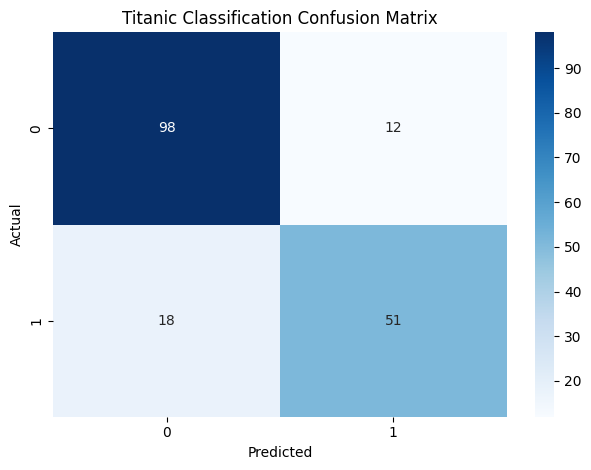

In [15]:
conf_matrix = confusion_matrix(y_test,y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues',fmt='d')

plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 4. Display the plot
plt.tight_layout()
plt.show()

In [16]:
model.best_estimator_['pre'] \
     .named_transformers_['cat'] \
     .named_steps['onehot'] \
     .get_feature_names_out(cat_features)


array(['sex_female', 'sex_male', 'class_First', 'class_Second',
       'class_Third', 'who_child', 'who_man', 'who_woman'], dtype=object)

In [18]:
feature_importances = model.best_estimator_['class'].feature_importances_

feature_names = numerical_features + list(model.best_estimator_['pre']
                                          .named_transformers_['cat']
                                          .named_steps['onehot']
                                          .get_feature_names_out(cat_features))

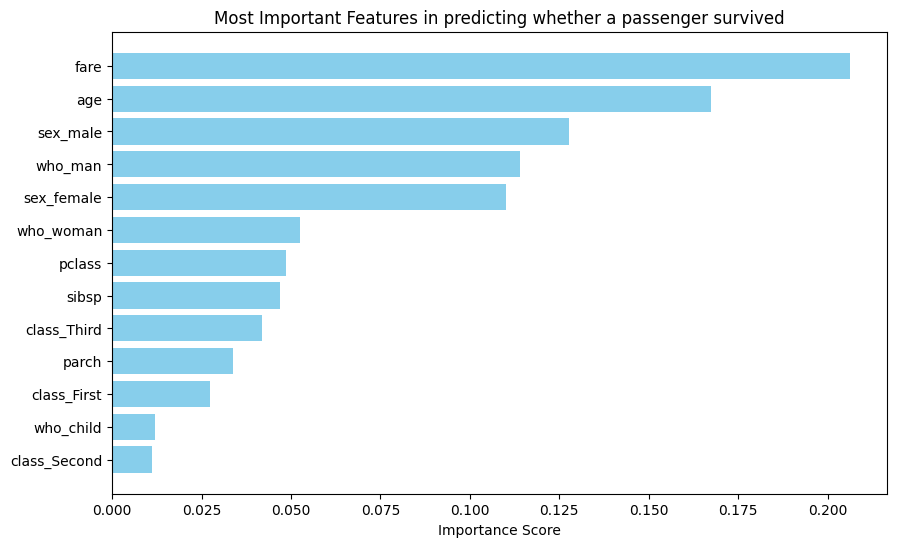


Test set accuracy: 83.24%


In [19]:
importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance' : feature_importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize  =(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis() 
plt.title('Most Important Features in predicting whether a passenger survived')
plt.xlabel('Importance Score')
plt.show()

# Print test score 
test_score = model.score(X_test, y_test)
print(f"\nTest set accuracy: {test_score:.2%}")